$$\large{\color{blue}{\space Challenge \: report : }}$$

$Realized \space By : Saifeddine \: Barkia $



**Note** : I trained this algorithm on a machine having 25 GB of RAM. Please take that into consideration if you want to run the model on your machine. 

For that reason, after testing the classical machine learning algorithms, please restart the kernel and load only the original images because it takes a lot of space in RAM. 

**Thank you for your understanding.**

#Imporing the necessary libraries

In [ ]:
# I need this for the feature extraction
!pip install  mahotas

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
from keras.utils import np_utils
import matplotlib.pyplot as plt
plt.close('all')

# For data pre-processing.

from skimage.io import imread
from skimage.transform import resize
from skimage.transform import rescale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# For feature extraction 

from sklearn.cluster import KMeans
from skimage.feature import greycomatrix, greycoprops
from skimage.feature import hog
from skimage.filters import sobel
import mahotas

# For the PCA part 

import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.offline as py

# Classical Machine learning

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef

from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

#Libraries for deep learning 

import tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Flatten,Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from keras.callbacks import  EarlyStopping

import warnings
warnings.filterwarnings('ignore')

# Loading data

For this challange , I worked on google colab, please, if you consider running the code again change the path for the data from here.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! unzip  "/content/drive/MyDrive/Train.zip"
! unzip  "/content/drive/MyDrive/Test.zip"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: Train/Train/4878_segCyt.bmp  
  inflating: Train/Train/4878_segNuc.bmp  
  inflating: Train/Train/4879.bmp    
  inflating: Train/Train/4879_segCyt.bmp  
  inflating: Train/Train/4879_segNuc.bmp  
  inflating: Train/Train/487_segCyt.bmp  
  inflating: Train/Train/487_segNuc.bmp  
  inflating: Train/Train/488.bmp     
  inflating: Train/Train/4883.bmp    
  inflating: Train/Train/4883_segCyt.bmp  
  inflating: Train/Train/4883_segNuc.bmp  
  inflating: Train/Train/4884.bmp    
  inflating: Train/Train/4884_segCyt.bmp  
  inflating: Train/Train/4884_segNuc.bmp  
  inflating: Train/Train/4886.bmp    
  inflating: Train/Train/4886_segCyt.bmp  
  inflating: Train/Train/4886_segNuc.bmp  
  inflating: Train/Train/4889.bmp    
  inflating: Train/Train/4889_segCyt.bmp  
  inflating: Train/Train/4889_segNuc.bmp  
  inflating: Train/Train/488_segCyt.bmp  
  inflating: Train/Train/488_segNuc.bmp  
  inflatin

In [ ]:
# Please change the paths if you want to run the code again
train_path = "Train/Train/"
test_path = "Test/Test/"
csv_file = "metadataTrain.csv"
submission_file_path = 'SampleSubmission.csv'
submission_file_path2 = 'SampleSubmission2.csv'

# Getting the data

For this challenge, we are given the original image of the Pap smear cell and two segmentation masks corresponding to the nucleus and cytoplasma parts. In order to train the machine learning models efficiently, I will train my classical machine learning models on 3 images, the original cell , the segmented image  using the nucleus part and the segmented image using the cytoplasma mask. <br>
So to do that, we need to have an efficient retrievel of data in order to have 3 images for each cell. After looking into the data ( both train and test folders), I remarked that the original images of the cells ( not the masks) doesn't contain the character **"_"**. So , I'm going first of all to store the id of images so that we can have a good correspondance between the different types of images afterwards.
<br> This operation is applied to both the train and test datasets.

In [ ]:
train_images_original_id = []
test_images_original_id = []
for directory_path in glob.glob(train_path + '/*'):
    label = directory_path.split("/")[-1]
    if( "_" not in label):
        train_images_original_id.append(os.path.splitext(label)[0])
                                
for directory_path in glob.glob(test_path+'/*'):
    label = directory_path.split("/")[-1]
    if( "_" not in label):
        test_images_original_id.append(os.path.splitext(label)[0])

# Converting the id's to int values and sorting them increasingly.
train_images_original_id = list(map(int, train_images_original_id))
train_images_original_id.sort()

test_images_original_id = list(map(int, test_images_original_id))
test_images_original_id.sort()

## Visualizing some samples

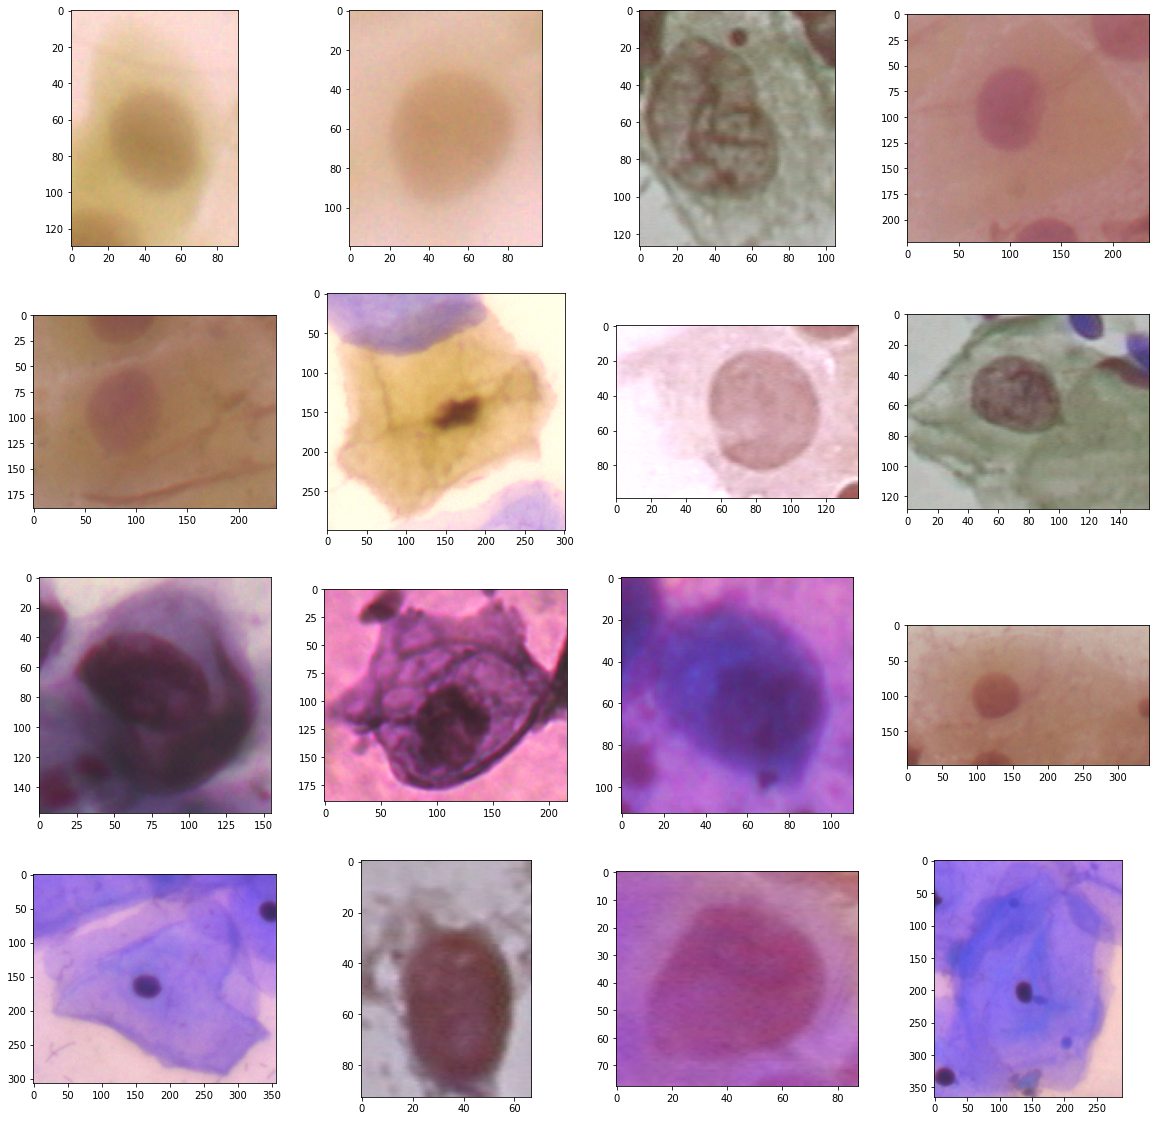

In [ ]:
plt.rcParams['figure.figsize'] = [20, 20]
fig, axs = plt.subplots(4,4)

for i in range(4):
  for j in range(4):
    index = 100*i + j
    img_path = train_path + "/" + str(train_images_original_id[index]) +".bmp"
    image = cv2.imread(img_path)
    axs[i, j].imshow(image)

After getting the image Ids, we will now proceed to load the 3 type of images each in different type of array ( the original image, the segmented image using the first mask and the segmented image using the second mask. 
<br> Before storing them, since the images doesn't come from the same distribution ( 2 different data sets ), they have different image sizes, so first of all, we need to resize them to a standard shape ( for the deep learning approach). 

In [ ]:
max_size = (0,0,3)
min_size =(1e9,1e9,3)
avg_height= 0
avg_width = 0
for x in train_images_original_id :
  img_path = train_path + "/" + str(x) +".bmp"
  img = cv2.imread(img_path)
  avg_height+= img.shape[0]
  avg_width+= img.shape[1]
  img = cv2.imread(img_path,) #Reading color images
  max_size = max( max_size, img.shape)
  min_size = min( min_size, img.shape)

print("The maximal image shape is " , max_size)

print("The minimal image shape is " , min_size)

print("The average image shape is ( " , avg_height//len(train_images_original_id) , ",",avg_width//len(train_images_original_id), ",3)")

The maximal image shape is  (553, 388, 3)
The minimal image shape is  (32, 103, 3)
The average image shape is (  181 , 203 ,3)


In image processing , the model performance varies with the size of the image , so I have decided to train my model with those different 3 shapes and compare the results. After, comparing the results, I noticed that working with **300x300** as a size of the images gave the best result. 

I commented every part of the following code to make my approach clear to the reader.

I will explain later in the model, how I'm going to use every numpy array generated by the following lines of code.


I didn't use image normalization because according to the literature, the minimal classification error is obtained when we consider all the intensity level of the images. So I just resized the images without any further manipulations on the images ( for the deep learning part). 

In [ ]:
# For the train data set
SIZE1 = 300
SIZE2 = 300
train_images_or = []
train_images_appMask1 = []
train_images_appMask2 = []
train_GlobalImageL = [] # For deep ( concatinating all images in the channels)
train_GlobalImage_OneChannelL = []
for x in train_images_original_id :
    img_path = train_path + "/" + str(x) +".bmp"
    img_path_mask1 = train_path + "/" + str(x) + "_segNuc.bmp"
    img_path_mask2 = train_path + "/" + str(x) + "_segCyt.bmp"

    #Reading the images from the repository 
    img = cv2.imread(img_path) 
    imgMask1 = cv2.imread(img_path_mask1) #Reading color images
    imgMask2 = cv2.imread(img_path_mask2) #Reading color images


    # Resizing the images to the standard shape.

    
    img_reslt1 = cv2.resize(img*imgMask1, (SIZE1, SIZE2)) # First segmented image
    img_reslt2 = cv2.resize(img*imgMask2, (SIZE1, SIZE2)) # Second segmented image
    img = cv2.resize(img, (SIZE1, SIZE2))
    # This list concatinates all the 3 images according the the number of channels 
    # we will have an image shape of ( SIZE1, SIZE2,9)
    # I will need it to explain my approach later for the deep learning model

    GlobalImage = np.concatenate( [img,img_reslt1,img_reslt2],axis=2 )

    # This list concatinates all the 3 images according the the number of channels 
    # we will have an image shape of ( SIZE1, SIZE2,3 ) each channel corresponds to the Red channel for each image
    # I will need it to explain my approach later for the deep learning model

    # GlobalImage_OneChannel = np.concatenate( [img[:,:,0],img_reslt1[:,:,0],img_reslt2[:,:,0]],axis=2 )

    # Storing the resulting images into the corresponding lists.

    train_images_or.append(img)
    train_images_appMask1.append(img_reslt1 )
    train_images_appMask2.append(img_reslt2)
    train_GlobalImageL.append(GlobalImage)
    # train_GlobalImage_OneChannelL.append(GlobalImage_OneChannel)

# Converting the lists to arrays

train_images_or = np.array(train_images_or)
train_images_appMask1 = np.array(train_images_appMask1)
train_images_appMask2 = np.array(train_images_appMask2)
train_GlobalImageL = np.array(train_GlobalImageL)
# train_GlobalImage_OneChannelL = np.array(train_GlobalImage_OneChannelL)

In [ ]:

# For the test data set

SIZE1 = 300
SIZE2 = 300
test_images_or = []
test_images_appMask1 = []
test_images_appMask2 = []
test_GlobalImageL = [] # for deep learning
test_GlobalImage_OneChannelL = []
for x in test_images_original_id :
    img_path = test_path + "/" + str(x) +".bmp"
    img_path_mask1 = test_path + "/" + str(x) + "_segNuc.bmp"
    img_path_mask2 = test_path + "/" + str(x) + "_segCyt.bmp"

    #Reading the images from the repository 
    img = cv2.imread(img_path) 
    imgMask1 = cv2.imread(img_path_mask1) #Reading color images
    imgMask2 = cv2.imread(img_path_mask2) #Reading color images


    # Resizing the images to the standard shape.

    
    img_reslt1 = cv2.resize(img*imgMask1, (SIZE1, SIZE2)) # First segmented image
    img_reslt2 = cv2.resize(img*imgMask2, (SIZE1, SIZE2)) # Second segmented image
    img = cv2.resize(img, (SIZE1, SIZE2))
    
    # This list concatinates all the 3 images according the the number of channels 
    # we will have an image shape of ( SIZE1, SIZE2,9)
    # I will need it to explain my approach later for the deep learning model

    GlobalImage = np.concatenate( [img,img_reslt1,img_reslt2],axis=2 )
    
    # This list concatinates all the 3 images according the the number of channels 
    # we will have an image shape of ( SIZE1, SIZE2,3 ) each channel corresponds to the Red channel for each image
    # I will need it to explain my approach later for the deep learning model

    #GlobalImage_OneChannel = np.concatenate( [img[:,:,0],img_reslt1[:,:,0],img_reslt2[:,:,0]],axis=2 )

    # Storing the resulting images into the corresponding lists.

    test_images_or.append(img)
    test_images_appMask1.append(img_reslt1 )
    test_images_appMask2.append(img_reslt2)
    test_GlobalImageL.append(GlobalImage)
    # test_GlobalImage_OneChannelL.append(GlobalImage_OneChannel)
# Converting the lists to arrays

test_images_or = np.array(test_images_or)
test_images_appMask1 = np.array(test_images_appMask1)
test_images_appMask2 = np.array(test_images_appMask2)
test_GlobalImageL = np.array(test_GlobalImageL)
# test_GlobalImage_OneChannelL = np.array(test_GlobalImage_OneChannelL)

For the deep learning and in order to gain space in ram , please uncomment this code and run it

In [ ]:
# For the train data set ( for deep learning)
SIZE1 = 300
SIZE2 = 300
train_images_or = []

for x in train_images_original_id :
    img_path = train_path + "/" + str(x) +".bmp"
 

    #Reading the images from the repository 
    img = cv2.imread(img_path) 



    # Resizing the images to the standard shape.

    img = cv2.resize(img, (SIZE1, SIZE2))
    # This list concatinates all the 3 images according the the number of channels 
    # we will have an image shape of ( SIZE1, SIZE2,9)


    # Storing the resulting images into the corresponding lists.

    train_images_or.append(img)

# Converting the lists to arrays

train_images_or = np.array(train_images_or)


# For the test data set


test_images_or = []
for x in test_images_original_id :
    img_path = test_path + "/" + str(x) +".bmp"

    #Reading the images from the repository 
    img = cv2.imread(img_path) 

    # Resizing the images to the standard shape.
    img = cv2.resize(img, (SIZE1, SIZE2))


    test_images_or.append(img)
    

test_images_or = np.array(test_images_or)


Here is an example of what we are going to train our model on.

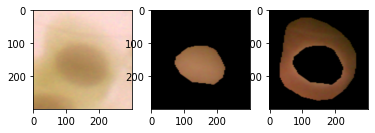

In [ ]:
plt.subplot(131)
plt.imshow(train_images_or[0])
plt.subplot(132)
plt.imshow(cv2.cvtColor(train_images_appMask1[0], cv2.COLOR_BGR2RGB))
plt.subplot(133)
plt.imshow(cv2.cvtColor(train_images_appMask2[0], cv2.COLOR_BGR2RGB))
plt.show()


# Classical Machine learning  

Before going for the deep learning approach,  I will give a try to the classical machine learning algorithms that we have seen in class and see their efficiency in the classification task. 

For that reason, given an image, we need to extract features from it to get the remarkable points that characterize the nature of the cell. 
<br> At first, I considered working with **statistical** feature extraction such as the **GLCM** : 
It's a statistical method of examining texture that considers the spatial relationship of pixels is the gray-level co-occurrence matrix (**GLCM**), also known as the gray-level spatial dependence matrix. The GLCM functions characterize the texture of an image by calculating how often pairs of pixel with specific values and in a specified spatial relationship occur in an image, creating a GLCM, and then extracting statistical measures from this matrix.

These statistics provide information about the texture of an image: 
<br>
* Contrast : Measures the local variations in the gray-level co-occurrence matrix.
<br>
* Correlation: Measures the joint probability occurrence of the specified pixel pairs.
<br>
* Energy : Provides the sum of squared elements in the GLCM. Also known as uniformity or the angular second moment.
<br>
* Homogeneity : Measures the closeness of the distribution of elements in the GLCM to the GLCM diagonal.


This feature extraction method is used a lot in the medical imaging. So I wanted to test its efficiency for our data set 


In [ ]:
def feature_extractor_GLCM(dataset):
    image_dataset = pd.DataFrame()
    for image in range(dataset.shape[0]):  #iterate through each file 
        #print(image)
        
        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        
        img = dataset[image, :,:,0]
    ################################################################
    #START ADDING DATA TO THE DATAFRAME
  
                
         #Full image
        #GLCM = greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
        GLCM = greycomatrix(img, [1], [0])       
        GLCM_Energy = greycoprops(GLCM, 'energy')[0]
        df['Energy'] = GLCM_Energy
        GLCM_corr = greycoprops(GLCM, 'correlation')[0]
        df['Corr'] = GLCM_corr       
        GLCM_diss = greycoprops(GLCM, 'dissimilarity')[0]
        df['Diss_sim'] = GLCM_diss       
        GLCM_hom = greycoprops(GLCM, 'homogeneity')[0]
        df['Homogen'] = GLCM_hom       
        GLCM_contr = greycoprops(GLCM, 'contrast')[0]
        df['Contrast'] = GLCM_contr


        GLCM2 = greycomatrix(img, [3], [0])       
        GLCM_Energy2 = greycoprops(GLCM2, 'energy')[0]
        df['Energy2'] = GLCM_Energy2
        GLCM_corr2 = greycoprops(GLCM2, 'correlation')[0]
        df['Corr2'] = GLCM_corr2       
        GLCM_diss2 = greycoprops(GLCM2, 'dissimilarity')[0]
        df['Diss_sim2'] = GLCM_diss2       
        GLCM_hom2 = greycoprops(GLCM2, 'homogeneity')[0]
        df['Homogen2'] = GLCM_hom2       
        GLCM_contr2 = greycoprops(GLCM2, 'contrast')[0]
        df['Contrast2'] = GLCM_contr2

        GLCM3 = greycomatrix(img, [5], [0])       
        GLCM_Energy3 = greycoprops(GLCM3, 'energy')[0]
        df['Energy3'] = GLCM_Energy3
        GLCM_corr3 = greycoprops(GLCM3, 'correlation')[0]
        df['Corr3'] = GLCM_corr3       
        GLCM_diss3 = greycoprops(GLCM3, 'dissimilarity')[0]
        df['Diss_sim3'] = GLCM_diss3       
        GLCM_hom3 = greycoprops(GLCM3, 'homogeneity')[0]
        df['Homogen3'] = GLCM_hom3       
        GLCM_contr3 = greycoprops(GLCM3, 'contrast')[0]
        df['Contrast3'] = GLCM_contr3

        GLCM4 = greycomatrix(img, [0], [np.pi/4])       
        GLCM_Energy4 = greycoprops(GLCM4, 'energy')[0]
        df['Energy4'] = GLCM_Energy4
        GLCM_corr4 = greycoprops(GLCM4, 'correlation')[0]
        df['Corr4'] = GLCM_corr4       
        GLCM_diss4 = greycoprops(GLCM4, 'dissimilarity')[0]
        df['Diss_sim4'] = GLCM_diss4       
        GLCM_hom4 = greycoprops(GLCM4, 'homogeneity')[0]
        df['Homogen4'] = GLCM_hom4       
        GLCM_contr4 = greycoprops(GLCM4, 'contrast')[0]
        df['Contrast4'] = GLCM_contr4
        
        GLCM5 = greycomatrix(img, [0], [np.pi/2])       
        GLCM_Energy5 = greycoprops(GLCM5, 'energy')[0]
        df['Energy5'] = GLCM_Energy5
        GLCM_corr5 = greycoprops(GLCM5, 'correlation')[0]
        df['Corr5'] = GLCM_corr5       
        GLCM_diss5 = greycoprops(GLCM5, 'dissimilarity')[0]
        df['Diss_sim5'] = GLCM_diss5       
        GLCM_hom5 = greycoprops(GLCM5, 'homogeneity')[0]
        df['Homogen5'] = GLCM_hom5       
        GLCM_contr5 = greycoprops(GLCM5, 'contrast')[0]
        df['Contrast5'] = GLCM_contr5
        
        
        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)
        
    return image_dataset

**As I explained in the beginning of this report, I'm going to use the original image and the 2 segmented image to train my model. I have the convection that adding the features from the 3 images will get as better results than using only the original cell image. It turns out that my instinct was right after I tested that.**
<br>
The following code provides 3 pandas dataframes that contains the features of each type of image.

## Feature extraction for the train data set

In [ ]:
image_features_or = feature_extractor_GLCM(train_images_or)
image_features_mask1 = feature_extractor_GLCM(train_images_appMask1)
image_features_mask2 = feature_extractor_GLCM(train_images_appMask2)

# Some processing before concatinating them together to pass it into the model 
image_features_or.index = train_images_original_id
image_features_mask1.index = train_images_original_id
image_features_mask2.index = train_images_original_id

All_features_train = pd.concat([image_features_or, image_features_mask1,image_features_mask2], axis=1)
All_features_train.columns = ['Energy1', 'Corr1', 'Diss_sim1', 'Homogen1', 'Contrast1', 'Energy21', 'Corr21',
       'Diss_sim21', 'Homogen21', 'Contrast21', 'Energy31', 'Corr31', 'Diss_sim31',
       'Homogen31', 'Contrast31', 'Energy41', 'Corr41', 'Diss_sim41', 'Homogen41',
       'Contrast41', 'Energy51', 'Corr51', 'Diss_sim51', 'Homogen51', 'Contrast51',
       'Energy2', 'Corr2', 'Diss_sim2', 'Homogen2', 'Contrast2', 'Energy22', 'Corr22',
       'Diss_sim22', 'Homogen22', 'Contrast22', 'Energy32', 'Corr32', 'Diss_sim32',
       'Homogen32', 'Contrast32', 'Energy42', 'Corr42', 'Diss_sim42', 'Homogen42',
       'Contrast42', 'Energy52', 'Corr52', 'Diss_sim52', 'Homogen52', 'Contrast52',
       'Energy3', 'Corr3', 'Diss_sim3', 'Homogen3', 'Contrast3', 'Energy23', 'Corr23',
       'Diss_sim23', 'Homogen23', 'Contrast23', 'Energy33', 'Corr33', 'Diss_sim33',
       'Homogen33', 'Contrast33', 'Energy43', 'Corr43', 'Diss_sim43', 'Homogen43',
       'Contrast43', 'Energy53', 'Corr53', 'Diss_sim53', 'Homogen53', 'Contrast53']




In [ ]:
All_features_train.index = All_features_train.index.map(int)
All_features_train.sort_index(inplace=True)
for col in All_features_train.columns:
    if len(All_features_train[col].unique()) == 1:
        All_features_train.drop(col,inplace=True,axis=1)

In [ ]:
All_features_train.head()

,Energy1,Corr1,Diss_sim1,Homogen1,Contrast1,Energy21,Corr21,Diss_sim21,Homogen21,Contrast21,Energy31,Corr31,Diss_sim31,Homogen31,Contrast31,Energy41,Corr41,Homogen41,Energy51,Corr51,Homogen51,Energy2,Corr2,Diss_sim2,Homogen2,Contrast2,Energy22,Corr22,Diss_sim22,Homogen22,Contrast22,Energy32,Corr32,Diss_sim32,Homogen32,Contrast32,Energy42,Corr42,Homogen42,Energy52,Corr52,Homogen52,Energy3,Corr3,Diss_sim3,Homogen3,Contrast3,Energy23,Corr23,Diss_sim23,Homogen23,Contrast23,Energy33,Corr33,Diss_sim33,Homogen33,Contrast33,Energy43,Corr43,Homogen43,Energy53,Corr53,Homogen53
2,0.062887,0.999209,0.712943,0.673347,1.012453,0.041438,0.995078,1.917048,0.397562,6.304994,0.034543,0.989496,2.826746,0.300504,13.465864,0.112900,1.0,1.0,0.112900,1.0,1.0,0.839645,0.998177,0.265084,0.939956,2.557213,0.835800,0.986885,0.766465,0.895293,18.499753,0.831960,0.971517,1.231096,0.876473,40.402102,0.841790,1.0,1.0,0.841790,1.0,1.0,0.617445,0.994950,0.580624,0.846361,4.127871,0.606295,0.964330,1.655960,0.738463,29.262200,0.595230,0.924190,2.626734,0.693596,62.409989,0.624313,1.0,1.0,0.624313,1.0,1.0
4,0.080214,0.997206,0.740256,0.662513,1.067570,0.051890,0.983264,1.953715,0.387391,6.403098,0.043945,0.966523,2.793831,0.295757,12.822463,0.150683,1.0,1.0,0.150683,1.0,1.0,0.757318,0.998071,0.318818,0.909778,2.069766,0.751977,0.986569,0.894366,0.843325,14.480112,0.746801,0.971675,1.392836,0.817117,30.682169,0.761045,1.0,1.0,0.761045,1.0,1.0,0.682599,0.993297,0.520959,0.865502,3.322297,0.671182,0.953948,1.476902,0.775751,22.919102,0.659892,0.904936,2.328497,0.737604,47.501966,0.689838,1.0,1.0,0.689838,1.0,1.0
6,0.047133,0.997024,1.255295,0.531262,3.087336,0.028796,0.976470,3.602166,0.265964,24.218956,0.023330,0.940853,5.679955,0.186137,60.440316,0.110842,1.0,1.0,0.110842,1.0,1.0,0.637139,0.997609,0.952397,0.820877,17.854760,0.629798,0.983040,2.811650,0.721675,127.046128,0.622713,0.963568,4.602712,0.686859,273.752904,0.642505,1.0,1.0,0.642505,1.0,1.0,0.625149,0.993845,1.377258,0.800911,27.995652,0.614470,0.958325,3.990864,0.701170,190.109428,0.604225,0.917446,6.350169,0.664337,377.295164,0.632782,1.0,1.0,0.632782,1.0,1.0
8,0.080639,0.973445,1.420223,0.477010,3.479220,0.058367,0.894483,2.911190,0.282906,13.774961,0.055436,0.862522,3.320870,0.256794,17.907627,0.202563,1.0,1.0,0.202563,1.0,1.0,0.912698,0.992520,0.328250,0.952333,9.971616,0.909512,0.964628,0.885903,0.932342,47.441324,0.906321,0.935032,1.372203,0.926053,87.672429,0.914429,1.0,1.0,0.914429,1.0,1.0,0.499720,0.991032,1.338016,0.725916,26.832754,0.486690,0.957806,3.338047,0.621415,126.275376,0.474462,0.923380,4.812113,0.597761,229.338621,0.517281,1.0,1.0,0.517281,1.0,1.0
9,0.055477,0.999405,0.732731,0.664180,1.039398,0.035231,0.996095,2.019551,0.377353,6.828373,0.029037,0.991075,3.066757,0.277562,15.629876,0.103560,1.0,1.0,0.103560,1.0,1.0,0.921021,0.997205,0.348384,0.966324,10.393645,0.918498,0.979768,1.037823,0.944682,75.714254,0.915953,0.956403,1.720791,0.935304,164.173266,0.922327,1.0,1.0,0.922327,1.0,1.0,0.599829,0.996432,1.244303,0.841836,30.961739,0.589225,0.974254,3.668575,0.728352,224.001504,0.578821,0.944772,6.020610,0.681945,481.750689,0.606656,1.0,1.0,0.606656,1.0,1.0


## Feature extraction for the test data set

* We will apply the same operations that we did for the train data set into to test data set.

In [ ]:
image_features_or_test = feature_extractor(test_images_or)
image_features_mask1_test = feature_extractor(test_images_appMask1)
image_features_mask2_test = feature_extractor(test_images_appMask2)

image_features_or_test.index = test_images_original_id
image_features_mask1_test.index = test_images_original_id
image_features_mask2_test.index = test_images_original_id

All_features_test = pd.concat([image_features_or_test, image_features_mask1_test,image_features_mask2_test], axis=1)


All_features_test.columns = ['Energy1', 'Corr1', 'Diss_sim1', 'Homogen1', 'Contrast1', 'Energy21', 'Corr21',
       'Diss_sim21', 'Homogen21', 'Contrast21', 'Energy31', 'Corr31', 'Diss_sim31',
       'Homogen31', 'Contrast31', 'Energy41', 'Corr41', 'Diss_sim41', 'Homogen41',
       'Contrast41', 'Energy51', 'Corr51', 'Diss_sim51', 'Homogen51', 'Contrast51',
       'Energy2', 'Corr2', 'Diss_sim2', 'Homogen2', 'Contrast2', 'Energy22', 'Corr22',
       'Diss_sim22', 'Homogen22', 'Contrast22', 'Energy32', 'Corr32', 'Diss_sim32',
       'Homogen32', 'Contrast32', 'Energy42', 'Corr42', 'Diss_sim42', 'Homogen42',
       'Contrast42', 'Energy52', 'Corr52', 'Diss_sim52', 'Homogen52', 'Contrast52',
       'Energy3', 'Corr3', 'Diss_sim3', 'Homogen3', 'Contrast3', 'Energy23', 'Corr23',
       'Diss_sim23', 'Homogen23', 'Contrast23', 'Energy33', 'Corr33', 'Diss_sim33',
       'Homogen33', 'Contrast33', 'Energy43', 'Corr43', 'Diss_sim43', 'Homogen43',
       'Contrast43', 'Energy53', 'Corr53', 'Diss_sim53', 'Homogen53', 'Contrast53']

All_features_test.index = All_features_test.index.map(int)

All_features_test.sort_index(inplace=True)

for col in All_features_test.columns:
    if len(All_features_test[col].unique()) == 1:
        All_features_test.drop(col,inplace=True,axis=1)
        

* I tested several models with this technique of model architechture, however, the results are not that good , only **(80)** % , which is not good enough (compared to the next method ).
<br> For that reason , I'm going to drop the statistical features of extraction and focus on the **shape**, **color** and **texture** descriptors because they are more important in this classification task. 

* So after several experiments on the right decriptors to choose, I found the best combination that gives the "best" results. I will explain every feature describer shortly. 

## Feature extraction used for the classical machine learning

**Note** : This section of the notebook takes a lot of time to run.

* I considered that **color intensity** is important for this classification task .

For that reason ,I extracted some color histogram of images ( some bins) instead of considering all the pixel intensity which will increase  the number of features and will harm the performances of most of the models. 

In [ ]:
def extract_color_histogram(img, n_bins=8):
    """Extract Color histogram of an image.
    :return feature: ndarray, contains n_bins*n_bins*n_bins HSV histogram features of the image
    """
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # convert the image to HSV color-space
    hist  = cv2.calcHist([hsv], [0, 1, 2], None, [n_bins, n_bins, n_bins], [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    feature = hist.flatten()
    return feature

**Haralick texture** features are calculated from a Gray Level Co-occurrence Matrix, (GLCM), a matrix that counts the co-occurrence of neighboring gray levels in the image. The GLCM is a square matrix that has the dimension of the number of gray levels N in the region of interest. But earlier , we considered all the GLCM features but here we are only taking 13 points which are the most relevant ones.

In [ ]:
def extract_haralick(img):
    """Extract Haralick features of an image. Haralick features are texture descriptors.
    :param img: ndarray, BGR image
    :return feature: ndarray, contains 13 Haralick features of the image
    """

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    feature = mahotas.features.haralick(gray).mean(axis=0)
    return feature

**Hu Moments** ( or rather Hu moment invariants ) are a set of 7 numbers calculated using central moments that are invariant to image transformations. The first 6 moments have been proved to be invariant to translation, scale, and rotation, and reflection. While the 7th moment’s sign changes for image reflection.

In [ ]:
def extract_hu_moments(img):
    """Extract Hu Moments feature of an image. Hu Moments are shape descriptors.
    :param img: ndarray, BGR image
    :return feature: ndarray, contains 7 Hu Moments of the image
    """
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(gray)).flatten()
    return feature

**Zernike moments** are complex moments with the orthogonal Zernike polynomials as kernel function, compared with other moments. Zernike moments have greater advantages in image rotation and low noise sensitivity. Because of the Zernike moments have image rotation invariance, and can construct arbitrary high order moments, it can be used for target recognition.

In [ ]:
def extract_zernike_moments(img, radius=21, degree=8):
    """Extract Zernike Moments feature of an image. Zernike Moments are shapre descriptors.
    :return feature: ndarray, contains 25 Zernike Moments of the image
    """
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    feature = mahotas.features.zernike_moments(gray, radius, degree)
    return feature

The **HOG** descriptor focuses on the structure or the shape of an object. Now you might ask, how is this different from the edge features we extract for images? In the case of edge features, we only identify if the pixel is an edge or not. HOG is able to provide the edge direction as well. This is done by extracting the gradient and orientation (or you can say magnitude and direction) of the edges. 
It is like the Sift descriptor that we have seen in IMA 201.

In [ ]:
def extract_hog(img, orientation=3, pixels_per_cell_1 = (40, 40)):
    feature,_ = hog(img, orientations=orientation, pixels_per_cell=pixels_per_cell_1, cells_per_block=(2, 2), visualize=True, multichannel=True)
    return feature

Now, we will put all those desciptors into one function.

In [ ]:
def feature_extractor(dataset):
    image_dataset = pd.DataFrame()
    for image in range(dataset.shape[0]):  #iterate through each file 
        #print(image)
        
        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        #Reset dataframe to blank after each loop.
        
        img = dataset[image,:,:]
        
        #START ADDING DATA TO THE DATAFRAME
        f_hog = extract_hog(img, orientation=3, pixels_per_cell_1 = (40, 40) )
        f_hog = f_hog.reshape(1,-1)
        

        ##Color
    
        f_color = extract_color_histogram (img,4)
        f_color = f_color.reshape(1,-1)

        ## Haralick
        fh = extract_haralick (img)
        fh = fh.reshape(1,-1)
        
        ## zernike
        fz = extract_zernike_moments (img)
        fz = fz.reshape(1,-1)

        # Stacking all the desciptors together

        res = np.hstack((f_hog,f_color,fh,fz))
                        
        col = list(range(0,res.shape[1]))
        df = pd.DataFrame(res,columns=col)
        
        #Append features from current image to the dataset
        image_dataset = image_dataset.append(df)
        
    return image_dataset

### Extracting the features for the train data set

In [ ]:
image_features_hog_or_train = feature_extractor(train_images_or)
image_features_hog_mask1_train = feature_extractor(train_images_appMask1)
image_features_hog_mask2_train = feature_extractor(train_images_appMask2)

image_features_hog_or_train.index = train_images_original_id
image_features_hog_mask1_train.index = train_images_original_id
image_features_hog_mask2_train.index = train_images_original_id

All_features_hog_train = pd.concat([image_features_hog_or_train, image_features_hog_mask1_train,image_features_hog_mask2_train], axis=1)

All_features_hog_train.index = All_features_hog_train.index.map(int)
All_features_hog_train.sort_index(inplace=True)
All_features_hog_train.columns = list(range(0,All_features_hog_train.shape[1]))

In [ ]:
All_features_hog_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601
2,0.318832,0.318832,0.246519,0.318832,0.318832,0.163463,0.318832,0.318832,0.248244,0.318832,0.318832,0.194038,0.328687,0.328687,0.154881,0.291224,0.328687,0.214498,0.328687,0.328687,0.183851,0.296076,0.328687,0.274806,0.295741,0.331875,0.217826,0.235387,0.331875,0.286642,0.300669,0.331875,0.279069,0.194601,0.331875,0.284262,0.243989,0.328790,0.297117,0.240697,...,0.0,0.0,0.377532,24.464810,0.991991,1527.026175,0.838311,57.282274,6083.639889,3.808071,4.443585,0.004742,1.404170,-0.682302,0.994863,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.307204,0.307204,0.225968,0.307204,0.307204,0.281289,0.307204,0.307204,0.239998,0.307204,0.307204,0.239206,0.309111,0.309111,0.292044,0.309111,0.309111,0.217567,0.309111,0.309111,0.248352,0.309111,0.309111,0.203216,0.316042,0.316042,0.221237,0.316042,0.316042,0.265702,0.316042,0.316042,0.206644,0.280654,0.316042,0.244562,0.314548,0.314548,0.253326,0.314548,...,0.0,0.0,0.461742,22.289012,0.990624,1188.303934,0.863996,44.354069,4730.926722,3.108064,3.634608,0.005951,1.272679,-0.669416,0.986791,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.307181,0.307181,0.213121,0.307181,0.307181,0.273629,0.307181,0.307181,0.307181,0.307181,0.307181,0.174550,0.352479,0.352479,0.287314,0.154152,0.352479,0.133860,0.352479,0.352479,0.183279,0.175592,0.352479,0.256701,0.143853,0.370826,0.124917,0.288805,0.370826,0.292335,0.163861,0.370826,0.239551,0.151785,0.370826,0.370826,0.259842,0.333138,0.263018,0.300228,...,0.0,0.0,0.387483,54.749174,0.989195,2532.887143,0.772556,73.493018,10076.799400,3.707898,4.660939,0.002613,1.871576,-0.573886,0.987852,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.290253,0.290253,0.270716,0.290253,0.290253,0.290253,0.290253,0.290253,0.290253,0.290253,0.290253,0.290253,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,0.288675,...,0.0,0.0,0.248267,84.000203,0.989115,3858.457035,0.808113,121.751441,15349.827939,4.109050,4.776590,0.003540,1.494081,-0.650198,0.994877,0.31831,0.461213,0.464807,0.326351,0.237634,0.048912,0.040060,0.051654,0.144077,0.129781,0.191161,0.138183,0.132948,0.151357,0.126983,0.023295,0.048355,0.044642,0.028137,0.060503,0.062063,0.064377,0.082794,0.074636,0.039677
9,0.231001,0.397473,0.203861,0.310675,0.397473,0.254588,0.136097,0.397473,0.082495,0.219515,0.397473,0.195677,0.312344,0.350055,0.255956,0.345974,0.350055,0.196637,0.220694,0.350055,0.196729,0.308196,0.350055,0.077568,0.339053,0.356097,0.192703,0.356097,0.328052,0.061872,0.302031,0.356097,0.076016,0.356097,0.356097,0.073732,0.347509,0.347509,0.068152,0.347509,...,0.0,0.0,0.357675,44.097352,0.993565,3425.478718,0.845458,91.763473,13657.817521,3.681067,4.242938,0.003605,1.385932,-0.687461,0.994005,0.31831,0.093867,0.104064,0.082134,0.036198,0.017489,0.027627,0.015398,0.028928,0.051996,0.038715,0.037250,0.025414,0.018565,0.008696,0.010261,0.011139,0.002716,0.024414,0.014755,0.036511,0.036515,0.019081,0.025898,0.024474


### Extracting the features for the test data set

In [ ]:
image_features_hog_or_test = feature_extractor(test_images_or)
image_features_hog_mask1_test = feature_extractor(test_images_appMask1)
image_features_hog_mask2_test = feature_extractor(test_images_appMask2)

image_features_hog_or_test.index = test_images_original_id
image_features_hog_mask1_test.index = test_images_original_id
image_features_hog_mask2_test.index = test_images_original_id

All_features_hog_test = pd.concat([image_features_hog_or_test, image_features_hog_mask1_test,image_features_hog_mask2_test], axis=1)

All_features_hog_test.index = All_features_hog_test.index.map(int)
All_features_hog_test.sort_index(inplace=True)
All_features_hog_test.columns = list(range(0,All_features_hog_test.shape[1]))

In [ ]:
All_features_hog_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601
0,0.344117,0.344117,0.116526,0.344117,0.344117,0.115436,0.344117,0.344117,0.100943,0.344117,0.344117,0.124809,0.334867,0.334867,0.110722,0.334867,0.334867,0.162889,0.334867,0.334867,0.119712,0.334867,0.334867,0.223137,0.349351,0.349351,0.140902,0.218848,0.349351,0.191852,0.349351,0.312613,0.193018,0.349351,0.314018,0.227212,0.186178,0.369501,0.163212,0.111919,...,0.0,0.0,0.310878,65.632138,0.992758,4530.503131,0.828356,115.121889,18056.380386,4.064874,4.701460,0.003175,1.475643,-0.682245,0.996076,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,0.225629,0.323888,0.222019,0.318971,0.287735,0.323888,0.218705,0.323888,0.194972,0.323888,0.323888,0.323888,0.262003,0.236347,0.309938,0.309938,0.309938,0.151148,0.309938,0.309938,0.304190,0.309938,0.309938,0.296115,0.345922,0.345922,0.160521,0.307837,0.345922,0.092619,0.330450,0.345922,0.314479,0.122517,0.345922,0.222433,0.338969,0.374527,0.101985,0.198049,...,0.0,0.0,0.309259,80.900448,0.989395,3813.711195,0.723464,102.177708,15173.944333,4.290908,5.438807,0.002421,2.188427,-0.556466,0.992171,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,0.332610,0.159679,0.332610,0.332610,0.178052,0.332610,0.332610,0.159915,0.332610,0.332610,0.179420,0.332610,0.320723,0.176533,0.320723,0.320723,0.160499,0.320723,0.320723,0.177889,0.320723,0.320723,0.297535,0.320723,0.304569,0.158550,0.304569,0.304569,0.231541,0.304569,0.304569,0.293922,0.304569,0.304569,0.304569,0.304569,0.310919,0.237214,0.310919,0.310919,...,0.0,0.0,0.294485,22.592358,0.989529,1078.627024,0.813578,57.217037,4291.915736,4.020598,4.697831,0.004923,1.487808,-0.661625,0.994995,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
7,0.411226,0.130244,0.258566,0.411226,0.159782,0.411226,0.411226,0.135403,0.077484,0.411226,0.065068,0.128628,0.367258,0.140673,0.367258,0.367258,0.284195,0.269400,0.367258,0.057287,0.113245,0.367258,0.281600,0.238893,0.304004,0.304004,0.304004,0.304004,0.285457,0.304004,0.304004,0.304004,0.277352,0.304004,0.304004,0.099118,0.313225,0.286133,0.313225,0.313225,...,0.0,0.0,0.406861,88.807098,0.992416,5853.474182,0.859051,110.212377,23325.089632,3.421681,3.931226,0.003161,1.346437,-0.691387,0.991999,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
12,0.291178,0.291178,0.291178,0.291178,0.291178,0.291178,0.291178,0.291178,0.291178,0.291178,0.291178,0.259553,0.306053,0.306053,0.306053,0.306053,0.306053,0.306053,0.306053,0.274895,0.225597,0.306053,0.306053,0.174709,0.306723,0.306723,0.306723,0.306723,0.306723,0.234148,0.306723,0.306723,0.170775,0.306723,0.273275,0.297827,0.300371,0.300371,0.251972,0.258084,...,0.0,0.0,0.148883,93.782643,0.986666,3517.353466,0.696811,145.694802,13975.631222,4.994199,6.107002,0.002260,1.949878,-0.586597,0.996742,0.31831,0.141054,0.05981,0.090713,0.01565,0.010132,0.051682,0.048644,0.037841,0.02111,0.027139,0.048064,0.0156,0.026844,0.017222,0.005831,0.030854,0.032181,0.029842,0.030729,0.007162,0.004428,0.009903,0.015402,0.02387


So the train and the test data sets have the same number of features and we are ready to feed the machine learning models to see the results.
**For all the machine learning algorithm that I'm going to use, I will apply grid search in order to obtain the best possible performance of the algorithm**

## Train and validation split

In [ ]:
df_labels = pd.read_csv(csv_file)
df_labels.index = df_labels['ID']
df_labels.drop("ID",axis=1,inplace=True)
df_labels.sort_index(inplace=True)
y = df_labels["ABNORMAL"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(All_features_hog_train, y, test_size=0.25, random_state=42,stratify=y)
print("Number of train samples", y_train.shape[0])
print("Number of validation  samples", y_test.shape[0])

Number of train samples 2190
Number of validation  samples 731


## PCA for data visualization

I will compare the results of the classifiers with and without the normalization of the features that I have extracted and see if the results improve.

In [ ]:
# Normalization
scaler = MinMaxScaler()

# We fit only on the training dataset

scaler.fit(X_train)

# We apply the learned parameters on the train set to the train and test sets

X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

In order, to interpret the results, we will use some dimensional reduction technique and try to visualize the data. 

In [ ]:
X= X_train
# Standardising the values
X_std = StandardScaler().fit_transform(X)

# Call the PCA method with components that explains 95% of the variablity of the data. 
pca = PCA(n_components=0.95)
pca.fit(X_std)
X_pca = pca.transform(X_std)

# For cluster coloring in our Plotly plots, remember to also restrict the target values 
Target = y_train

In [ ]:
trace0 = go.Scatter(
    x = X_pca[:,0],
    y = X_pca[:,1],
#     name = Target,
#     hoveron = Target,
    mode = 'markers',
    text = Target,
    showlegend = False,
    marker = dict(
        size = 8,
        color = Target,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [trace0]

layout = go.Layout(
    title= 'Principal Component Analysis (PCA)',
    hovermode= 'closest',
    xaxis= dict(
         title= 'First Principal Component',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Second Principal Component',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= True
)


fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

* So here what the data looks like if we consider only the first and second principal components.

## Training data on machine learning algorithms.

*SVM*

* Since there is no pre defined MCC metric, I used the f1 score to validate the algorithm since it's the closest one to the MCC.

In [ ]:
p_grid_lsvm = {'C': [1e-4,1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC()
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="f1", cv=5)
#grid_lsvm contain the best estimator
grid_lsvm.fit(X_train, y_train)
print("Best training Score ( f1 ): {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
print("SVM test score (f1 ) :",grid_lsvm.score(X_test,y_test))

y_pred = grid_lsvm.predict(X_test)

y_pred_train = grid_lsvm.predict(X_train)

print("MCC coeff for the training set ",matthews_corrcoef(y_train, y_pred_train))
print("\n")
print("MCC coeff for the validation set ",matthews_corrcoef(y_test, y_pred))


Best training Score ( f1 ): 0.8399172130313725
Best training params: {'C': 1}
SVM test score (f1 ) : 0.21978021978021975
MCC coeff for the training set  0.21425932123642993


MCC coeff for the validation set  0.2431043526057672


* I have decided to start with a simple SVM approach. These results were not satisfying since as we can see in the fig above the data is **not** **linearly separable**. I think that is normal to obtain poor results because of that depsite the fact that SVMs re good with high dimensions. 

* For that reason, I decided to apply some standardisation to the data to improve the results

*SVM applied on normalized data*

In [ ]:
p_grid_lsvm = {'C': [1e-4,1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC()
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="f1", cv=5)
#grid_lsvm contain the best estimator
grid_lsvm.fit(X_train_scale, y_train)
print("Best training Score (f1):  {}".format(grid_lsvm.best_score_))
print("Best training params : {}".format(grid_lsvm.best_params_))
print("SVM test score ( f1 ):",grid_lsvm.score(X_test_scale,y_test))

y_pred = grid_lsvm.predict(X_test_scale)

y_pred_train = grid_lsvm.predict(X_train_scale)

print("MCC coeff for the training set ",matthews_corrcoef(y_train, y_pred_train))
print("\n")
print("MCC coeff for the validation set ",matthews_corrcoef(y_test, y_pred))

Best training Score (f1):  0.9363154648755001
Best training params : {'C': 0.1}
SVM test score ( f1 ): 0.9366459627329193
MCC coeff for the training set  0.991682177867542


MCC coeff for the validation set  0.8591091116286238


* As we can see, for the SVM algorithm, applying data normalization improved the performance of the algorithm. it went from **0.32** for the Mathews correlation coefficient to **0.85** , which is considered to be a huge improvement. So , once more , as we have seen in the labs sessions, having the same scale for all the features is important for SVM.


* Now, I will apply the non linear SVM and see if the results are going to improve.  For that reason, to overcome this lack of performance :  I will try to use some kernel in order to map the data into a high dimensional space and we may have a linear transformation in that latent space. ( after testing the polynomial and the gaussian kernel, the 'rbf' gave better results ).



*Non linear SVM*

In [ ]:
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="f1", cv=5)

#grid_nlsvm contain the best estimator
grid_nlsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
print("SVM test score :",grid_nlsvm.score(X_test,y_test))

y_pred = grid_nlsvm.predict(X_test)

y_pred_train = grid_nlsvm.predict(X_train)

print("MCC coeff for the training set ",matthews_corrcoef(y_train, y_pred_train))
print("\n")
print("MCC coeff for the validation set ",matthews_corrcoef(y_test, y_pred))

Best training Score: 0.7213400133799591
Best training params: {'C': 2, 'gamma': 0.0001}
SVM test score : 0.7219251336898396
MCC coeff for the training set  1.0


MCC coeff for the validation set  0.1557482413887557


*Non linear SVM with  normalized data*

In [ ]:
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="f1", cv=5)

#grid_nlsvm contain the best estimator
grid_nlsvm.fit(X_train_scale, y_train)
print("Best training Score ( f1 ): {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
print("SVM test score ( f1 ) :",grid_nlsvm.score(X_test_scale,y_test))

y_pred = grid_nlsvm.predict(X_test_scale)

y_pred_train = grid_nlsvm.predict(X_train_scale)

print("MCC coeff for the training set ",matthews_corrcoef(y_train, y_pred_train))
print("\n")
print("MCC coeff for the validation set ",matthews_corrcoef(y_test, y_pred))

Best training Score ( f1 ): 0.949717501546073
Best training params: {'C': 6, 'gamma': 0.01}
SVM test score ( f1 ) : 0.9543773119605425
MCC coeff for the training set  0.9990763626632586


MCC coeff for the validation set  0.8975453097968088


* As predicted , the non linear SVM outperforms the SVM algorithm since the data is **non linear.**

*KNN*

In [ ]:
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}

KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="f1", cv=5)
grid_KNN.fit(X_train, y_train)

print("Best training Score(f1): {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
print("KNN test score ( f1 ) :",grid_KNN.score(X_test,y_test))

y_pred = grid_KNN.predict(X_test)

y_pred_train = grid_KNN.predict(X_train)

print("MCC coeff for the training set ",matthews_corrcoef(y_train, y_pred_train))
print("\n")
print("MCC coeff for the validation set ",matthews_corrcoef(y_test, y_pred))

Best training Score(f1): 0.8887845066451184
Best training params: {'n_neighbors': 9}
KNN test score ( f1 ) : 0.9015151515151515
MCC coeff for the training set  0.7930774443547267


MCC coeff for the validation set  0.7861945983834437


* Based on the MCC coefficient, the **KNN** algorithm, performed better than the SVM, but the non linear svm out performs it. Atually, this is due to the curse of dimensionality : it doesn't perform good on datasets with large number of features and also it's sensitive to outliers.

*KNN with normalized data*

In [ ]:
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="f1", cv=5)
grid_KNN.fit(X_train_scale, y_train)
print("Best training Score(f1): {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
print("KNN test score (f1):",grid_KNN.score(X_test_scale,y_test))

y_pred = grid_KNN.predict(X_test_scale)

y_pred_train = grid_KNN.predict(X_train_scale)

print("MCC coeff for the training set ",matthews_corrcoef(y_train, y_pred_train))
print("\n")
print("MCC coeff for the validation set ",matthews_corrcoef(y_test, y_pred))

Best training Score(f1): 0.7286532710396091
Best training params: {'n_neighbors': 1}
KNN test score (f1): 0.7437774524158127
MCC coeff for the training set  1.0


MCC coeff for the validation set  0.5667799758049389


* As seen in course, KNN, doesn't need scaling. Even more , we can see that the performances of the algorithm dropped to 0.56 from 0.76

*Logitisic regression*

In [ ]:
grid={"C":[0.01,0.02,0.1,1,2,3,10,20,30], "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("Best Validation Score: {}".format(logreg_cv.best_score_))
print("Best params: {}".format(logreg_cv.best_params_))
print("Logistic regression validation score ( f1 ) :",logreg_cv.score(X_test,y_test))

y_pred = logreg_cv.predict(X_test)

y_pred_train = logreg_cv.predict(X_train)

print("MCC coeff for the training set ",matthews_corrcoef(y_train, y_pred_train))
print("\n")
print("MCC coeff for the validation set ",matthews_corrcoef(y_test, y_pred))

Best Validation Score: 0.8557077625570775
Best params: {'C': 0.01, 'penalty': 'l2'}
Random Forest test score : 0.8632010943912448
MCC 0.7245563163093386


* It's also expected for the logistic regression to give poor performances since we are dealing with non linear data and it's very dependent on the proper presentation of data. In order for this algorithm to give good results , important variables / features should be identified for it to work well. For that reason, I'm going to try it later with the PCA and compare it with those results.

*Logistic regression with normalized data*

In [ ]:
grid={"C":[0.01,0.02,0.1,1,2,3,10,20,30], "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train_scale,y_train)

print("Best Validation Score: {}".format(logreg_cv.best_score_))
print("Best params: {}".format(logreg_cv.best_params_))
print("Logistic regression test score :",logreg_cv.score(X_test_scale,y_test))

y_pred = logreg_cv.predict(X_test_scale)

y_pred_train = logreg_cv.predict(X_train_scale)

print("MCC coeff for the training set ",matthews_corrcoef(y_train, y_pred_train))
print("\n")
print("MCC coeff for the validation set ",matthews_corrcoef(y_test, y_pred))

Best Validation Score: 0.9420091324200911
Best params: {'C': 1, 'penalty': 'l2'}
Random Forest test score : 0.5540355677154583
MCC 0.876472032061801


* Logistic regression performs better with scaled data.

As we can see , the previous algorithm gave respactable results, but we seek to imporve more by testing the **boosting** and **ensembling** methods that we have seen. 

*Adaboost*

In [ ]:
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2, 5,10,20,30,40,50,100],
              "learning_rate" : [ 0.01,0.05,0.1, 0.5,1]
             }


DTC = DecisionTreeClassifier(random_state = 42, max_features = "auto",max_depth = None)
ABC = AdaBoostClassifier(base_estimator = DTC)
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, scoring = 'roc_auc')
grid_search_ABC.fit(X_train, y_train.ravel())

print("Best Validation Score (f1 score ): {}".format(grid_search_ABC.best_score_))
print("Best params: {}".format(grid_search_ABC.best_params_))
print("Random Forest test score :",grid_search_ABC.score(X_test,y_test))

y_pred = grid_search_ABC.predict(X_test)

y_pred_train = grid_search_ABC.predict(X_train)

print("MCC coeff for the training set ",matthews_corrcoef(y_train, y_pred_train))
print("\n")
print("MCC coeff for the validation set ",matthews_corrcoef(y_test, y_pred))

Best Validation Score (f1 score ): 0.9077671863169698
Best params: {'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'learning_rate': 0.01, 'n_estimators': 5}
Random Forest test score : 0.9231235325304855
MCC  0.847596281144993


*Adaboost with normalized data*

In [ ]:
# Adaboost
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2, 5,10,20,30,40,50,100],
              "learning_rate" : [ 0.01,0.05,0.1, 0.5,1]
             }


DTC = DecisionTreeClassifier(random_state = 42, max_features = "auto",max_depth = None)
ABC = AdaBoostClassifier(base_estimator = DTC)
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, scoring = 'roc_auc')
grid_search_ABC.fit(X_train_scale, y_train.ravel())

print("Best Validation Score (f1 score ): {}".format(grid_search_ABC.best_score_))
print("Best params: {}".format(grid_search_ABC.best_params_))
print("Adaboost  test score (f1 ) :",grid_search_ABC.score(X_test_scale,y_test))

y_pred = grid_search_ABC.predict(X_test_scale)

y_pred_train = grid_search_ABC.predict(X_train_scale)

print("MCC coeff for the training set ",matthews_corrcoef(y_train, y_pred_train))
print("\n")
print("MCC coeff for the validation set ",matthews_corrcoef(y_test, y_pred))

Best Validation Score (f1 score ): 0.9082969860026138
Best params: {'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'learning_rate': 0.5, 'n_estimators': 10}
Random Forest test score : 0.9212527455881239
MCC  0.8422567358730073


* Boosting emthods iteratively corrects the mistakes of the weak classifier and improves the performances of the model by combining weak learners.  Generally boosting methods doesn't need scaling , which is confirmed here. The results didn't imrprove at all when we normalized the data. The adaboost algorithm didn't provide better result because we have a lot of outliers here and it's known to be sensitive to outliers.

*Random Forest*

In [ ]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30,35], 'min_samples_leaf': [2,3,4,5,6,8,10,12], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='f1', cv=5) # I used the accuracy as a metric in order to keep the comparision between the classifiers ( normaly it's better to use f1-score)
grid_RF.fit(X_train, y_train.ravel())

print("Best Validation Score (f1 score ): {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))

y_pred = grid_RF.predict(X_test)

y_pred_train = grid_RF.predict(X_train)

print("MCC coeff for the training set ",matthews_corrcoef(y_train, y_pred_train))
print("\n")
print("MCC coeff for the validation set ",matthews_corrcoef(y_test, y_pred))

Best Validation Score (f1 score ): 0.9607677351123656
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 35}
Random Forest test score : 0.9599027946537059
MCC  0.9088824370264108


*Random forest with normalized data.*

In [ ]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30,35], 'min_samples_leaf': [2,3,4,5,6,8,10,12], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='f1', cv=5) # I used the accuracy as a metric in order to keep the comparision between the classifiers ( normaly it's better to use f1-score)
grid_RF.fit(X_train_scale, y_train.ravel())

print("Best Validation Score (f1 score ): {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test_scale,y_test))

y_pred = grid_RF.predict(X_test_scale)

y_pred_train = grid_RF.predict(X_train_scale)

print("MCC coeff for the training set ",matthews_corrcoef(y_train, y_pred_train))
print("\n")
print("MCC coeff for the validation set ",matthews_corrcoef(y_test, y_pred))

Best Validation Score (f1 score ): 0.9612228907206546
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 25}
Random Forest test score : 0.975609756097561
MCC  0.9448319409555841


* The Random forest algorithm performs better on huge amount of data since it reduces both the variance and the error of the model. It has little impact of outliers and it doesn't face the overfitting problem. I opted to use this algorithm because we are dealing with data with large number of features and data that presents outliers. 
* Surprisingly, when applied to normalized data, the RF algorithm performed better


So as we can see, the Random forest algorithm have out performed all the other algorithms and with a 0.91 MCC score. furthermore, when we applied the normalization, the results did improve even more and we got 0.94 as a score for the MCC metric. ( Normally , the decision tree algorithm is not sensible to normalization but in our case , it did improve the results )


**Conclusion :** For the traditional machine learning algorithm, the random forest did gave us the best result and I have a score of 0.92 on the public test data.


<br> I believe that we cannot improve furthermore the results using classical machine learning algorithms, so for that reason, I'm going to tackle the deep learning approach and try to improve the results.

**Note :** I will note use the PCA technqiue for all the algorithms since the results will not improve a lot. I wil ltest it only on the logistic regression and see if my previous hypothesis holds.

**Applying PCA to reduce the number of features**




# Deep learning approach ( using CNNs )

## First approach

In this section, I'm going to explain my different approaches that I used to approach the classification problem. 

* My first idea is to train the model on the 3 images ( the original image, the segmented image using the nucleus mask and the segmented image using the cytoplasma mask. )

 For that reason, when I loaded the data in the previous section, I created a list that contains an image having **9 channels** where the first 3 channels corresponds to the original image and so on and so forth. 

 I believe that training the model on all those channels simultinuosly will yield to better results than training seperatly all the models

 Unfortunately , due to the lack of computational power, I could not train this type of model because of the fact that I have to construct the model from scratch because I could not use the pre-trained models ( using transfer learning ( I will explain it in the next session ) ) because they require images having only 3 channels. <br> Moreover, even that I can build the model based on ResNet or Inception.. architecture, it will take a lot of time to train and nothing will guarantee having good results since there are a lot of hyperparameters.

**Note** : As a continuation in this idea, I decided to take the first channel from each image and train the model on it . In other words, I would take the Green channel from the original image , the green channel from the first segmented image and the green channel from the second segmented image . The results that I have obtained were worse than the one obtaiend using classical machine learning models , so I decided to drop this idea and opt for my second approach.

## Second approach

In this approach, I decided to train 3 models independitly on each type of images ( 3 different types ) and see if the aggregation of those models can yield to good results.

As I said before , for computational reasons, I decided to opt for the transfer learning technique and freeze  some layers of the pre-trained model  ( make the untrainable since they are trained before on the imagenet and they have millions of parameters ). So my goal is to fine tune the model on the dataset that we are going to work on. 

I tried many pre-trained models, like **VGG16**, **VGG19**, **Resnet50**, **DenseNet** and the different versions of **EfficientNet** with the different batch size parameters and different learning rate parameters for ( the Adam and RMSprop optimization algorithms ). 


Also, I applied the data augmentation technique with various parameters ( rotation,  horizontal and vertical flip )  to see the effect of that on the model. 

As we know, the problem with the deep learning that there is a lot of hyperparameters to try and to choose and it is very dificult to find the best combination that gives the best results. I believe that once choosing the optimization parameter , an important parameter to choose is the value of the learning rate because it is very crucial, espacially that choosing a bad value van result in stucking in a local minimum that we can't espace without some perturbation. In order to prevent that, I decided to apply a learning rate decay after a certain number of epochs ( as a call back for the algorithm ).


## Training only on the original image

First of all, we are going to split our training data set into train and validation sets, so that we can generalize the model on the test data set.
I choose, 75% for training and 25% as a validation set.

**Note** : I have already done that for the traditional machine learning algorithm, but I repeated that here as a reminder.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_images_or, y, test_size=0.3, random_state=42)
print("Number of train samples", y_train.shape[0])
print("Number of test  samples", y_test.shape[0])

Number of train samples 2044
Number of test  samples 877


## Building the model

After several hyper paramter tuning, I decided to build the following model; I choose **Resnet50** as a base model for my training. I tried both freezing all the layers and fine tuning ( retraining ) some of them. 

The fine tuning approach gave better results. I re-trained the last 30 layers of the ResNet50 model.


For the fully connected neural network , I decided to choose 4 layer : the first one with **256**  neurones and the second one with **128** neurons and the third one with **64** neurones.  For the first 3 layers, I choose to work with **Relu** as an activation function. 

For regularization purposes and to speed up the training , I applied  the " only **dropout** technique" (**batch normalization technique**  didn't improve the results ) for this task.

For the last layer, which consists of only one neurone, I choose the **sigmoid** function as the activation function. 



In [ ]:
pretrained_Resnet = tensorflow.keras.applications.ResNet50(include_top=False, 
                                             weights='imagenet', input_shape=(SIZE1,SIZE1,3))

# Freezing the first layers of the model.
for i in range(len(pretrained_Resnet.layers)-30):
    pretrained_Resnet.layers[i].trainable = False

# Making the last 30 layers trainable
for i in range( len(pretrained_Resnet.layers)-30, len(pretrained_Resnet.layers)):
    pretrained_Resnet.layers[i].trainable = True
    
# creating the model

model = Sequential()
model.add(pretrained_Resnet)
model.add(Flatten())


model.add(Dense(256, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.05))



#output layer
model.add(Dense(1, activation='sigmoid'))


94773248/94765736 [==============================] - 1s 0us/step


Here is a summuray of the architecture of our model.


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 10, 10, 2048)      23587712  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               52429056  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8


The following part of code is for the data augmentation technique that I have applied to the images in order to improve the performance of the model and to generalize it. 

There are plenty of transformation to choose from, but since we are interested in the classification of cell images , it's not reasonable to consider shear and shift transformations since they modify the size of the image ( which is an important feature for the classification part ). for that reason I chose only **horizental flip**, **vertical flip**, and **rotation** as transformations.

After trying many values, I decided to work with **16** as **batch size**.


In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,vertical_flip=True,rotation_range=90,
		zoom_range=0.2,
		)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size = 16
    )

validation_generator = val_datagen.flow(
    X_test,
    y_test,
    batch_size = 16
)

We are going to choose **Adam** as the optimization parameter with **0.00001** as a learning rate (I tested several learning rates and different optimization algorithm and I decided to choose these two ). 

Obviously, we are going to choose the **binary crossentropy** for the first challenge since we have a binary classification problem. Also , since the metric is the **Mathews correlation coefficient** , we are going to evaluate the model on it. We need to implement it since it doesn't figure on the default metrics on sklearn.

In [ ]:
def mcc_metric(y_true, y_pred):

  predicted = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
  true_pos = tf.math.count_nonzero(predicted * y_true)
  true_neg = tf.math.count_nonzero((predicted - 1) * (y_true - 1))
  false_pos = tf.math.count_nonzero(predicted * (y_true - 1))
  false_neg = tf.math.count_nonzero((predicted - 1) * y_true)
  x = tf.cast((true_pos + false_pos) * (true_pos + false_neg) 
      * (true_neg + false_pos) * (true_neg + false_neg), tf.float32)
  
  return tf.cast((true_pos * true_neg) - (false_pos * false_neg), tf.float32) / tf.sqrt(x)

In [ ]:
model.compile(optimizer=Adam(lr=0.0001),
               loss='binary_crossentropy',
               metrics=[mcc_metric])

In deep learning problems, most of the annoying problem that we are going to face are overfitting and being stuck in a local minima, for that reason, I decided to have two call backs :

* the first deals with the overfitting problem , so if the validation loss doesn't improve for 10 epochs , we are going to interupt the training 

* The second call back, deals with being stuck in a local minima , for that case after 20 epochs, I decided to multiply the learning rate by an exponential coefficient to 'guarentee' converging to a global minima.

I will train the model forn 50 epochs ( may be less if we have the early stopping).

In [ ]:
batch_size = 16
def scheduler(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

early = EarlyStopping(monitor='val_loss', mode='auto',patience =10)


Fitting the model

In [ ]:
history = model.fit_generator(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[callback,early],
    steps_per_epoch = (len(X_train)//batch_size),
    verbose=1, )

Epoch 1/50
127/127 [==============================] - 88s 404ms/step - loss: 0.5791 - mcc_metric: nan - val_loss: 0.0942 - val_mcc_metric: 0.9337
Epoch 2/50
127/127 [==============================] - 47s 369ms/step - loss: 0.1870 - mcc_metric: 0.8709 - val_loss: 0.1091 - val_mcc_metric: 0.9281
Epoch 3/50
127/127 [==============================] - 47s 368ms/step - loss: 0.1334 - mcc_metric: 0.9012 - val_loss: 0.0803 - val_mcc_metric: 0.9432
Epoch 4/50
127/127 [==============================] - 47s 367ms/step - loss: 0.1039 - mcc_metric: 0.9245 - val_loss: 0.0903 - val_mcc_metric: 0.9425
Epoch 5/50
127/127 [==============================] - 47s 367ms/step - loss: 0.0858 - mcc_metric: 0.9408 - val_loss: 0.0783 - val_mcc_metric: 0.9288
Epoch 6/50
127/127 [==============================] - 47s 368ms/step - loss: 0.0842 - mcc_metric: 0.9345 - val_loss: 0.0724 - val_mcc_metric: 0.9466
Epoch 7/50
127/127 [==============================] - 47s 367ms/step - loss: 0.0678 - mcc_metric: 0.9548 - va

In [ ]:
print( "Evaluation on the valdiation set ", model.evaluate(X_test, y_test, batch_size=16) ) 

55/55 [==============================] - 5s 91ms/step - loss: 0.0490 - mcc_metric: 0.9681
Evaluation on the valdiation set  [0.04895801097154617, 0.9680657982826233]


Let's visualize the performance of the network

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'mcc_metric', 'val_loss', 'val_mcc_metric', 'lr'])


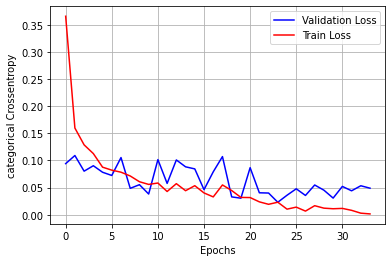

In [ ]:
fig,ax=plt.subplots(1,1)

ax.set_xlabel('Epochs')
ax.set_ylabel('categorical Crossentropy')

vy=history.history['val_loss']
ty=history.history['loss']
ax.plot(vy,'b',label='Validation Loss')
ax.plot(ty,'r',label='Train Loss')

plt.legend()
plt.grid()
fig.canvas.draw()

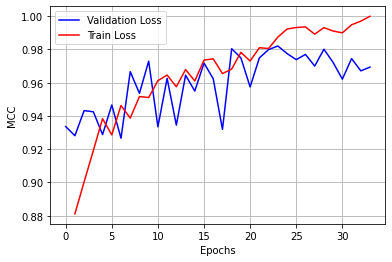

In [ ]:
fig,ax=plt.subplots(1,1)

ax.set_xlabel('Epochs')
ax.set_ylabel('MCC')

vy=history.history['val_mcc_metric']
ty=history.history['mcc_metric']
ax.plot(vy,'b',label='Validation Loss')
ax.plot(ty,'r',label='Train Loss')

plt.legend()
plt.grid()
fig.canvas.draw()

In [ ]:
plt.rcParams['figure.figsize'] = [4, 4]

c = 0
for i in range(len(predic)):
  if (predic[i]!=y_test[i]):
    c += 1
    print("True label :", y_test[i])
    plt.imshow(test_Images[i]/255)
    plt.show()
    if c == 10:
      break

### Submission File

In [ ]:
df_sub = pd.read_csv(submission_file_path)
df_sub["ID"] = test_images_original_id
ypred = model.predict(test_images_or)
ypred[ypred > 0.6] = int(1)
ypred[ypred <= 0.6] = int(0)
df_sub["ABNORMAL"] = ypred
# Convert to int type

df_sub["ABNORMAL"] = df_sub["ABNORMAL"].astype(int)
# Save to csv file

df_sub_resnet.to_csv('Binary.csv',index=False)

## Multi classification problem

For the classification part, it will be repititve to do all the work again. For that reason, I will focus only on the  deep learning approach. 

I will consider the same architecture that I have used for the binary classification problem. 
I will simply code the y_train and y_test to one hot encoding and change the last layer of the network to 9 neurones with a softmax activation function , and I will also change the loss to categorical loss since we are deadling with multiclassification problem.

As mentioned in the challenge, we will evaluate the model this time on the weighted accuracy. All the rest will remain the same.

In [ ]:
df_labels = pd.read_csv(csv_file)
df_labels.index = df_labels['ID']
df_labels.drop("ID",axis=1,inplace=True)
df_labels.sort_index(inplace=True)
y = df_labels["GROUP"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_images_or, y, test_size=0.3, random_state=42)

# Converting the y to one hot encoding
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# Loading the pre-trained Resnet
pretrained_Resnet = tensorflow.keras.applications.ResNet50(include_top=False, 
                                             weights='imagenet', input_shape=(SIZE1,SIZE1,3))
for i in range(len(pretrained_Resnet.layers)-30):
    pretrained_Resnet.layers[i].trainable = False
for i in range(len(pretrained_Resnet.layers)-30,len(pretrained_Resnet.layers)):
    pretrained_Resnet.layers[i].trainable = True

    
model = Sequential()
model.add(pretrained_Resnet)
model.add(Flatten())

#adding hidden layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.05))


#output layer

model.add(Dense(9, activation='softmax'))

# Data augmentation

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,vertical_flip=True,rotation_range=90,
		zoom_range=0.2,
		)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size = 16
    )

validation_generator = val_datagen.flow(
    X_test,
    y_test,
    batch_size = 16
)

# Callbacks
def scheduler(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

early = EarlyStopping(monitor='val_loss', mode='auto',patience =20)

# Compiling and fitting the model

batch_size = 16
model.compile(optimizer=Adam(lr=0.00001),
               loss='CategoricalCrossentropy',
                weighted_metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    epochs=50,
    validation_data=validation_generator,callbacks=[callback,early],verbose=1,steps_per_epoch = (len(X_train)//batch_size) )

Epoch 1/50
127/127 [==============================] - 50s 372ms/step - loss: 1.6029 - accuracy: 0.4924 - val_loss: 0.5078 - val_accuracy: 0.8267
Epoch 2/50
127/127 [==============================] - 47s 371ms/step - loss: 0.6257 - accuracy: 0.7835 - val_loss: 0.3853 - val_accuracy: 0.8563
Epoch 3/50
127/127 [==============================] - 46s 365ms/step - loss: 0.5133 - accuracy: 0.8285 - val_loss: 0.3566 - val_accuracy: 0.8609
Epoch 4/50
127/127 [==============================] - 46s 365ms/step - loss: 0.4249 - accuracy: 0.8444 - val_loss: 0.3022 - val_accuracy: 0.8791
Epoch 5/50
127/127 [==============================] - 46s 365ms/step - loss: 0.4152 - accuracy: 0.8567 - val_loss: 0.2891 - val_accuracy: 0.8917
Epoch 6/50
127/127 [==============================] - 46s 365ms/step - loss: 0.3708 - accuracy: 0.8659 - val_loss: 0.2815 - val_accuracy: 0.8928
Epoch 7/50
127/127 [==============================] - 46s 364ms/step - loss: 0.3282 - accuracy: 0.8765 - val_loss: 0.2677 - val_ac

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


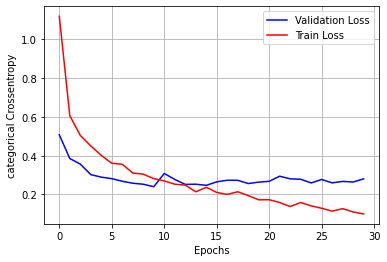

In [ ]:
fig,ax=plt.subplots(1,1)

ax.set_xlabel('Epochs')
ax.set_ylabel('categorical Crossentropy')

vy=history.history['val_loss']
ty=history.history['loss']
ax.plot(vy,'b',label='Validation Loss')
ax.plot(ty,'r',label='Train Loss')

plt.legend()
plt.grid()
fig.canvas.draw()

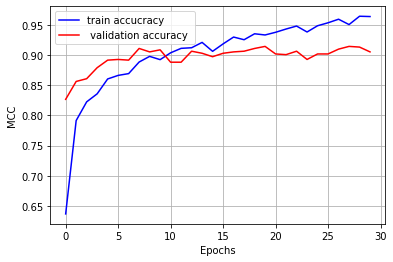

In [ ]:
fig,ax=plt.subplots(1,1)

ax.set_xlabel('Epochs')
ax.set_ylabel('MCC')

vy=history.history['accuracy']
ty=history.history['val_accuracy']
ax.plot(vy,'b',label='train accucracy')
ax.plot(ty,'r',label=' validation accuracy ')

plt.legend()
plt.grid()
fig.canvas.draw()

### Submission file

In [ ]:
df_sub = pd.read_csv("SampleSubmission.csv")
df_sub["ID"] = test_images_original_id
ypred = model.predict(test_images_or)
ypred = np.argmax(ypred,axis=1) # getting the index with the maximum probability
df_sub["ABNORMAL"] = ypred
# Convert to int type

df_sub["ABNORMAL"] = df_sub["ABNORMAL"].astype(int)
# Save to csv file

df_sub_resnet.to_csv('Multiclass.csv',index=False)

# Conclusion

During this challenge, first , I tried to apply the various method that we learned during IMA 201 to extract the characteristic points in each image and feed it classical machine learning algorithms rather than training on the pixel of the images. After that, since we are dealing with many features , the Random forest out performed all the classical algorithm with 0.92 MCC on the public data set.

After that, I focused on the deep leanring approach using CNNs since we are dealing with images, CNNs are the best way to approach this kind of problem, it allows extracting many features and guarantee good performances ( better than classic machine learning at least ). 

For both binary and multiclassification challenges, due to the lack of computational resources, I opted for transfer learning with fine tuning of some layers ( ResNet50 ). To avoid the problem of overfitting, I used call backs , one for early stopping whenever the validation loss didn't decrease after 10 epochs and one to decrease the learning rate to avoid being stucked in a local minimum. Also, I used the dropout technique in the training process.

Finally, I managed to score **0.967** in the private dataset for the binary classification ( using MCC as a metric ) and **0.832** for the multiclassification problem.

